# Laboratory exercise 1

## Imports

In [1]:
import string
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import tqdm
from sklearn.model_selection import train_test_split
from nltk import pos_tag_sents, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from gensim.models import Word2Vec

## Download nltk dependencies

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

## Read data

In [3]:
df = pd.read_csv('data/MAMI/TRAINING/training.csv', sep='\t')

In [4]:
df

,file_name,misogynous,shaming,stereotype,objectification,violence,Text Transcription
0,1.jpg,0,0,0,0,0,Milk Milk.zip
1,10.jpg,1,0,0,0,1,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S..."
2,1000.jpg,0,0,0,0,0,BREAKING NEWS: Russia releases photo of DONALD...
3,10000.jpg,0,0,0,0,0,MAN SEEKING WOMAN Ignad 18 O
4,10006.jpg,0,0,0,0,0,Me explaining the deep lore of. J.R.R. Tolkein...
...,...,...,...,...,...,...,...
9995,15002.jpg,0,0,0,0,0,WAITING FOR THE END OF THE COVID imgflip.com
9996,15003.jpg,0,0,0,0,0,SMART WOMEN ARE AROUND imgflip.com
9997,15004.jpg,0,0,0,0,0,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com
9998,15005.jpg,0,0,0,0,0,COOKING FOR MY WIFE imgflip.com


## Preprocessing

### Check for missing values

In [5]:
df.isnull().sum()

file_name             0
misogynous            0
shaming               0
stereotype            0
objectification       0
violence              0
Text Transcription    0
dtype: int64

### Get X and y dataframes

In [6]:
X = df[['Text Transcription']].copy()
y = df[['misogynous', 'shaming', 'stereotype', 'objectification', 'violence']].copy()

In [7]:
X

,Text Transcription
0,Milk Milk.zip
1,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S..."
2,BREAKING NEWS: Russia releases photo of DONALD...
3,MAN SEEKING WOMAN Ignad 18 O
4,Me explaining the deep lore of. J.R.R. Tolkein...
...,...
9995,WAITING FOR THE END OF THE COVID imgflip.com
9996,SMART WOMEN ARE AROUND imgflip.com
9997,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com
9998,COOKING FOR MY WIFE imgflip.com


In [8]:
y

,misogynous,shaming,stereotype,objectification,violence
0,0,0,0,0,0
1,1,0,0,0,1
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
9995,0,0,0,0,0
9996,0,0,0,0,0
9997,0,0,0,0,0
9998,0,0,0,0,0


### Tokenize and filter text (Problem 1.A)

In [9]:
def lower_and_word_tokenize_text_series(text_series: pd.Series) -> pd.Series:
    return text_series.str.lower().apply(word_tokenize)

In [10]:
tokens_list = lower_and_word_tokenize_text_series(X['Text Transcription'])

In [11]:
tokens_list

0                                        [milk, milk.zip]
1       [roses, are, red, ,, violets, are, blue, if, y...
2       [breaking, news, :, russia, releases, photo, o...
3                     [man, seeking, woman, ignad, 18, o]
4       [me, explaining, the, deep, lore, of, ., j.r.r...
                              ...                        
9995    [waiting, for, the, end, of, the, covid, imgfl...
9996             [smart, women, are, around, imgflip.com]
9997    [good, girls, are, behind, the, corner, imgfli...
9998                [cooking, for, my, wife, imgflip.com]
9999    [listen, tomorrow, will, be, monday, imgflip.c...
Name: Text Transcription, Length: 10000, dtype: object

In [12]:
def filter_stopwords_and_punctuation(tokens_list: pd.Series) -> pd.Series:
    stopset = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    custom_set = {
        '...',
        '""',
        '``',
        "''"
    }
    filter_set = stopset | punctuation | custom_set
    
    def filter_token(token):
        return token not in filter_set and not re.match(r'\w+\.(com|net)', token)

    return tokens_list.apply(
        lambda tokens: list(filter(filter_token, tokens))
    )

In [13]:
tokens_list = filter_stopwords_and_punctuation(tokens_list)

In [14]:
tokens_list

0                                        [milk, milk.zip]
1       [roses, red, violets, blue, n't, say, yes, 'll...
2       [breaking, news, russia, releases, photo, dona...
3                        [man, seeking, woman, ignad, 18]
4       [explaining, deep, lore, j.r.r, tolkein, 's, w...
                              ...                        
9995                                [waiting, end, covid]
9996                               [smart, women, around]
9997                        [good, girls, behind, corner]
9998                                      [cooking, wife]
9999                           [listen, tomorrow, monday]
Name: Text Transcription, Length: 10000, dtype: object

In [15]:
def get_vocabulary(tokens_list: pd.Series) -> pd.Series:
    return tokens_list.explode().value_counts()

In [16]:
vocabulary = get_vocabulary(tokens_list)
f'{len(vocabulary)=}'

'len(vocabulary)=21255'

In [17]:
top_20 = vocabulary.head(20)
top_20

's            1820
n't           1416
women         1208
like           863
woman          682
'm             643
get            538
're            526
wife           502
girlfriend     485
men            477
man            437
girl           432
one            426
kitchen        414
house          376
call           356
girls          352
female         351
make           346
Name: Text Transcription, dtype: int64

In [18]:
def barplot_vocabulary(voc: pd.Series) -> None:
    voc.sort_values().plot(kind='barh', figsize=(12, 8))

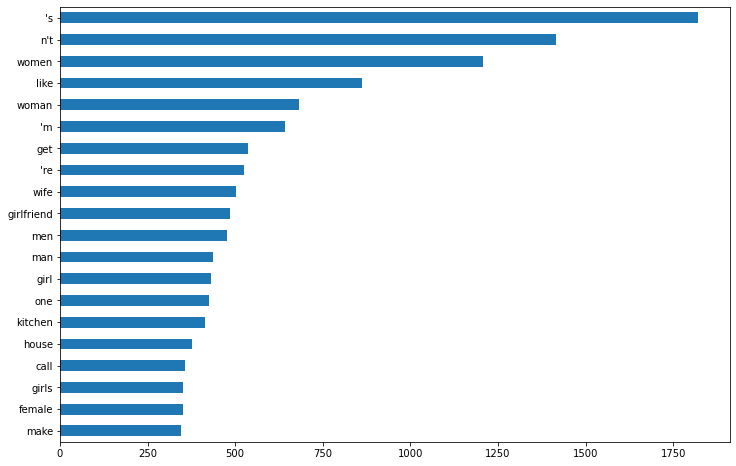

In [19]:
barplot_vocabulary(top_20)

### Remove words with occurence less than k from vocabulary (Problem 1.B)

In [20]:
def vocabulary_with_removed_less_than_k(vocabulary, k):
    return vocabulary[vocabulary > k]

In [21]:
voc_stats = []
for k in (0, 1, 2, 3, 4, 5, 10, 15, 20):
    voc = vocabulary_with_removed_less_than_k(vocabulary, k)
    voc_stats.append({
        'k': k,
        'len': len(voc),
        'ratio': len(voc) / len(vocabulary)
    })
df_voc_stats = pd.DataFrame(voc_stats)

In [22]:
df_voc_stats

,k,len,ratio
0,0,21255,1.000000
1,1,8254,0.388332
2,2,5526,0.259986
3,3,4235,0.199247
4,4,3452,0.162409
5,5,2949,0.138744
6,10,1648,0.077535
7,15,1128,0.053070
8,20,849,0.039944


<AxesSubplot:xlabel='k', ylabel='len'>

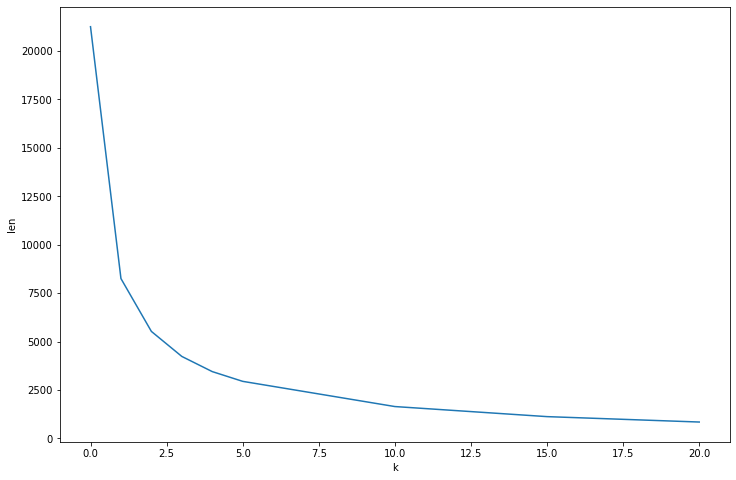

In [23]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_voc_stats, x='k', y='len')

### Lemmanize text (Problem 1.V)

In [24]:
lemmatizer = WordNetLemmatizer()

In [25]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [26]:
def lemmatize_tokens_list(tokens_list):
    lemmatized_tokens_list = []
    for pos_tags in pos_tag_sents(tokens_list):
        lemmatized_tokens_list.append([
            lemmatizer.lemmatize(token, pos=get_wordnet_pos(pos))
            for token, pos in pos_tags
        ])
    return pd.Series(lemmatized_tokens_list)


In [27]:
lemmatized_tokens_list = lemmatize_tokens_list(tokens_list)

In [28]:
lemmatized_tokens_list

0                                        [milk, milk.zip]
1       [rose, red, violet, blue, n't, say, yes, 'll, ...
2       [break, news, russia, release, photo, donald, ...
3                           [man, seek, woman, ignad, 18]
4       [explain, deep, lore, j.r.r, tolkein, 's, worl...
                              ...                        
9995                                   [wait, end, covid]
9996                               [smart, woman, around]
9997                         [good, girl, behind, corner]
9998                                         [cook, wife]
9999                           [listen, tomorrow, monday]
Length: 10000, dtype: object

In [29]:
lemmatized_vocabulary = get_vocabulary(lemmatized_tokens_list)
f'{len(lemmatized_vocabulary)=}'

'len(lemmatized_vocabulary)=18921'

In [30]:
lemmatized_top_20 = lemmatized_vocabulary.head(20)
lemmatized_top_20

woman         1900
's            1820
n't           1416
get            991
like           921
make           770
girl           766
'm             643
say            563
're            526
go             516
wife           510
girlfriend     485
call           485
men            481
want           445
man            445
one            440
feminist       435
look           419
dtype: int64

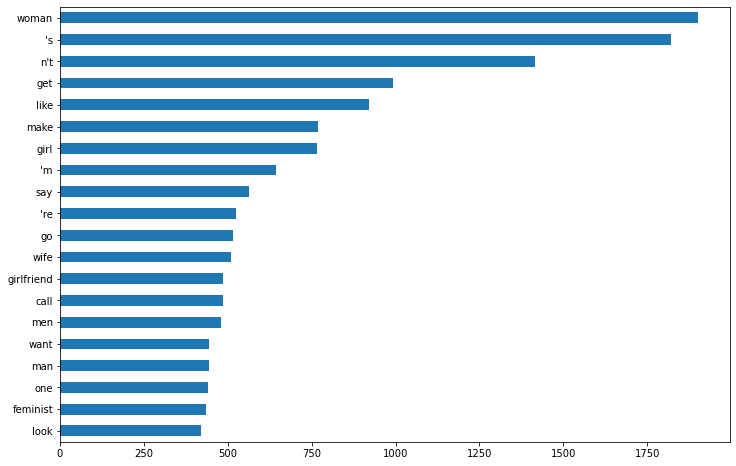

In [31]:
barplot_vocabulary(lemmatized_top_20)

In [32]:
lemmatized_voc_stats = []
for k in (0, 1, 2, 3, 4, 5, 10, 15, 20):
    voc = vocabulary_with_removed_less_than_k(lemmatized_vocabulary, k)
    lemmatized_voc_stats.append({
        'k': k,
        'len': len(voc),
        'ratio': len(voc) / len(lemmatized_vocabulary)
    })
df_lemmatized_voc_stats = pd.DataFrame(lemmatized_voc_stats)

<AxesSubplot:xlabel='k', ylabel='len'>

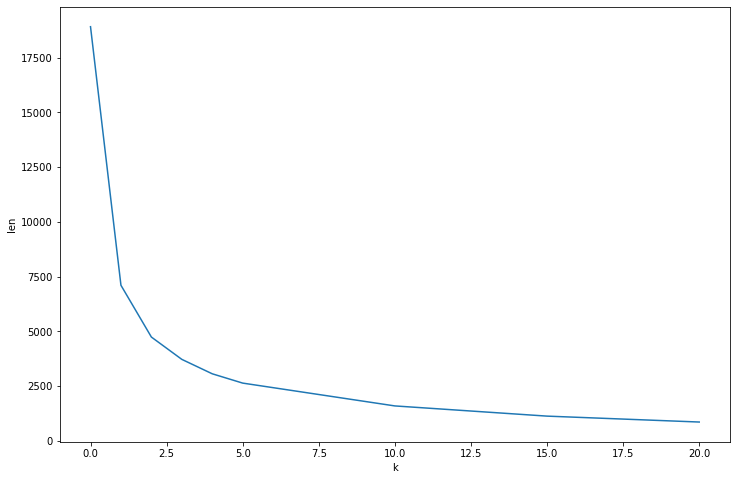

In [33]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_lemmatized_voc_stats, x='k', y='len')

### Add n-gram features to X (Problem 2)

#### Add 1-grams

In [34]:
X['Lemmatized tokens'] = lemmatized_tokens_list
X

,Text Transcription,Lemmatized tokens
0,Milk Milk.zip,"[milk, milk.zip]"
1,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S...","[rose, red, violet, blue, n't, say, yes, 'll, ..."
2,BREAKING NEWS: Russia releases photo of DONALD...,"[break, news, russia, release, photo, donald, ..."
3,MAN SEEKING WOMAN Ignad 18 O,"[man, seek, woman, ignad, 18]"
4,Me explaining the deep lore of. J.R.R. Tolkein...,"[explain, deep, lore, j.r.r, tolkein, 's, worl..."
...,...,...
9995,WAITING FOR THE END OF THE COVID imgflip.com,"[wait, end, covid]"
9996,SMART WOMEN ARE AROUND imgflip.com,"[smart, woman, around]"
9997,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com,"[good, girl, behind, corner]"
9998,COOKING FOR MY WIFE imgflip.com,"[cook, wife]"


In [35]:
def add_contains_features(X, match_words):
    X_copy = X.copy()
    for word in match_words:
        X_copy[f'contains_{word}'] = X['Lemmatized tokens'].apply(lambda tokens: word in tokens)
    return X_copy.copy()

In [36]:
match_words = vocabulary_with_removed_less_than_k(lemmatized_vocabulary, k=20).index
match_words

Index(['woman', ''s', 'n't', 'get', 'like', 'make', 'girl', ''m', 'say', ''re',
       ...
       'bat', 'argument', 'recipe', 'mate', 'grow', 'mine', 'bacon', 'actual',
       'sarah', '80'],
      dtype='object', length=856)

In [37]:
X = add_contains_features(X, match_words)
X

C:\Users\MARTIN~1\AppData\Local\Temp/ipykernel_23156/2465247661.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X_copy[f'contains_{word}'] = X['Lemmatized tokens'].apply(lambda tokens: word in tokens)


,Text Transcription,Lemmatized tokens,contains_woman,contains_'s,contains_n't,contains_get,contains_like,contains_make,contains_girl,contains_'m,...,contains_bat,contains_argument,contains_recipe,contains_mate,contains_grow,contains_mine,contains_bacon,contains_actual,contains_sarah,contains_80
0,Milk Milk.zip,"[milk, milk.zip]",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S...","[rose, red, violet, blue, n't, say, yes, 'll, ...",False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,BREAKING NEWS: Russia releases photo of DONALD...,"[break, news, russia, release, photo, donald, ...",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,MAN SEEKING WOMAN Ignad 18 O,"[man, seek, woman, ignad, 18]",True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Me explaining the deep lore of. J.R.R. Tolkein...,"[explain, deep, lore, j.r.r, tolkein, 's, worl...",False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,WAITING FOR THE END OF THE COVID imgflip.com,"[wait, end, covid]",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9996,SMART WOMEN ARE AROUND imgflip.com,"[smart, woman, around]",True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9997,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com,"[good, girl, behind, corner]",False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
9998,COOKING FOR MY WIFE imgflip.com,"[cook, wife]",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Add 2-grams

In [38]:
def add_contains_n_grams_features(X, match_n_grams):
    X_copy = X.copy()
    for n_gram in match_n_grams:
        X_copy[f'contains_{"_".join(n_gram)}'] = X_copy['Lemmatized tokens'].apply(lambda tokens: n_gram in tokens)
    return X_copy.copy()

In [39]:
n_grams_2 = X['Lemmatized tokens'].apply(lambda tokens: list(nltk.ngrams(tokens, n=2)))
n_grams_2

0                                      [(milk, milk.zip)]
1       [(rose, red), (red, violet), (violet, blue), (...
2       [(break, news), (news, russia), (russia, relea...
3       [(man, seek), (seek, woman), (woman, ignad), (...
4       [(explain, deep), (deep, lore), (lore, j.r.r),...
                              ...                        
9995                          [(wait, end), (end, covid)]
9996                    [(smart, woman), (woman, around)]
9997     [(good, girl), (girl, behind), (behind, corner)]
9998                                       [(cook, wife)]
9999             [(listen, tomorrow), (tomorrow, monday)]
Name: Lemmatized tokens, Length: 10000, dtype: object

In [40]:
vocabulary_n_grams_2 = get_vocabulary(n_grams_2)

In [41]:
vocabulary_n_grams_2.head(20)

(ca, n't)           235
(woman, 's)         154
(make, mematic)     120
(look, like)        112
(gon, na)            97
(wo, n't)            85
(n't, know)          70
(meme, center)       67
(year, old)          67
(n't, get)           65
(make, sandwich)     62
(wan, na)            58
(toilet, paper)      58
(let, 's)            57
(woman, like)        57
(change, mind)       48
(equal, right)       45
(leave, house)       44
(like, woman)        42
(woman, n't)         41
Name: Lemmatized tokens, dtype: int64

In [42]:
match_n_grams = vocabulary_with_removed_less_than_k(vocabulary_n_grams_2, k=20).index
match_n_grams

Index([        ('ca', 'n't'),       ('woman', ''s'),   ('make', 'mematic'),
            ('look', 'like'),         ('gon', 'na'),         ('wo', 'n't'),
             ('n't', 'know'),    ('meme', 'center'),       ('year', 'old'),
              ('n't', 'get'),  ('make', 'sandwich'),         ('wan', 'na'),
         ('toilet', 'paper'),         ('let', ''s'),     ('woman', 'like'),
          ('change', 'mind'),    ('equal', 'right'),    ('leave', 'house'),
           ('like', 'woman'),      ('woman', 'n't'),   ('back', 'kitchen'),
            ('girl', 'like'),       ('n't', 'want'),       ('n't', 'need'),
               ('ai', 'n't'),     ('video', 'game'),     ('first', 'time'),
       ('get', 'girlfriend'),    ('woman', 'woman'),       (''s', 'right'),
         ('woman', 'driver'), ('call', 'ambulance'),         ('get', 'ta'),
         ('corona', 'virus'),       (''m', 'sorry'),      ('men', 'woman'),
                  ('â', '’'),         (''s', 'day'),          (''s', 'go'),
        ('wa

In [43]:
X = add_contains_n_grams_features(X, match_n_grams)
X

,Text Transcription,Lemmatized tokens,contains_woman,contains_'s,contains_n't,contains_get,contains_like,contains_make,contains_girl,contains_'m,...,contains_wife_'s,contains_call_duty,contains_n't_cheat,contains_64_64,contains_beat_woman,contains_uuuu_uuuu,contains_fat_girl,contains_finally_get,contains_n't_like,contains_men_'s
0,Milk Milk.zip,"[milk, milk.zip]",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S...","[rose, red, violet, blue, n't, say, yes, 'll, ...",False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,BREAKING NEWS: Russia releases photo of DONALD...,"[break, news, russia, release, photo, donald, ...",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,MAN SEEKING WOMAN Ignad 18 O,"[man, seek, woman, ignad, 18]",True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Me explaining the deep lore of. J.R.R. Tolkein...,"[explain, deep, lore, j.r.r, tolkein, 's, worl...",False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,WAITING FOR THE END OF THE COVID imgflip.com,"[wait, end, covid]",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9996,SMART WOMEN ARE AROUND imgflip.com,"[smart, woman, around]",True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9997,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com,"[good, girl, behind, corner]",False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
9998,COOKING FOR MY WIFE imgflip.com,"[cook, wife]",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Add 3-grams

In [44]:
n_grams_3 = X['Lemmatized tokens'].apply(lambda tokens: list(nltk.ngrams(tokens, n=3)))
n_grams_3

0                                                      []
1       [(rose, red, violet), (red, violet, blue), (vi...
2       [(break, news, russia), (news, russia, release...
3       [(man, seek, woman), (seek, woman, ignad), (wo...
4       [(explain, deep, lore), (deep, lore, j.r.r), (...
                              ...                        
9995                                 [(wait, end, covid)]
9996                             [(smart, woman, around)]
9997       [(good, girl, behind), (girl, behind, corner)]
9998                                                   []
9999                         [(listen, tomorrow, monday)]
Name: Lemmatized tokens, Length: 10000, dtype: object

In [45]:
vocabulary_n_grams_3 = get_vocabulary(n_grams_3)

In [46]:
vocabulary_n_grams_3.head(20)

(like, woman, like)             26
('m, gon, na)                   25
(woman, 's, right)              24
(cite, deep, magic)             23
(magic, witch, write)           23
(deep, magic, witch)            23
(woman, 's, day)                21
(64, 64, 64)                    18
(get, back, kitchen)            17
(ca, n't, get)                  17
(woman, like, like)             16
('s, gon, na)                   16
(â, ’, ¸)                       14
(woman, ca, n't)                13
(strong, independent, woman)    12
(sarah, jessica, parker)        12
(uuuu, uuuu, uuuu)              12
(bet, 's, thinking)             12
(finally, get, girlfriend)      11
('s, thinking, woman)           11
Name: Lemmatized tokens, dtype: int64

In [47]:
match_n_grams = vocabulary_with_removed_less_than_k(vocabulary_n_grams_3, k=20).index
match_n_grams

Index([  ('like', 'woman', 'like'),         (''m', 'gon', 'na'),
          ('woman', ''s', 'right'),   ('cite', 'deep', 'magic'),
       ('magic', 'witch', 'write'),  ('deep', 'magic', 'witch'),
            ('woman', ''s', 'day')],
      dtype='object')

In [48]:
X = add_contains_n_grams_features(X, match_n_grams)
X

,Text Transcription,Lemmatized tokens,contains_woman,contains_'s,contains_n't,contains_get,contains_like,contains_make,contains_girl,contains_'m,...,contains_finally_get,contains_n't_like,contains_men_'s,contains_like_woman_like,contains_'m_gon_na,contains_woman_'s_right,contains_cite_deep_magic,contains_magic_witch_write,contains_deep_magic_witch,contains_woman_'s_day
0,Milk Milk.zip,"[milk, milk.zip]",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S...","[rose, red, violet, blue, n't, say, yes, 'll, ...",False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,BREAKING NEWS: Russia releases photo of DONALD...,"[break, news, russia, release, photo, donald, ...",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,MAN SEEKING WOMAN Ignad 18 O,"[man, seek, woman, ignad, 18]",True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Me explaining the deep lore of. J.R.R. Tolkein...,"[explain, deep, lore, j.r.r, tolkein, 's, worl...",False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,WAITING FOR THE END OF THE COVID imgflip.com,"[wait, end, covid]",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9996,SMART WOMEN ARE AROUND imgflip.com,"[smart, woman, around]",True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9997,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com,"[good, girl, behind, corner]",False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
9998,COOKING FOR MY WIFE imgflip.com,"[cook, wife]",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Word2Vec embeddings (Problem 3)

In [49]:
model = Word2Vec(X['Lemmatized tokens'], vector_size=50, min_count=1, window=5, sg=0)

In [50]:
X['Embeddings'] = X['Lemmatized tokens'].apply(lambda tokens: np.asarray([model.wv[token] for token in tokens]))
X['Avg embeddings'] = X['Embeddings'].apply(lambda embeddings: np.mean(embeddings, axis=0) if len(embeddings) > 0 else np.zeros(50))

### Train test split

Problem 2

In [51]:
X_2 = X.drop(['Text Transcription', 'Lemmatized tokens', 'Embeddings', 'Avg embeddings'], axis=1).copy()

Problem 3

In [52]:
X_3 = X['Avg embeddings'].copy().to_list()

In [53]:
X_3

[array([-0.00563447,  0.03586034,  0.01403013, -0.0081182 , -0.02066711,
        -0.06465179,  0.10722409,  0.13752283, -0.09874469, -0.04905812,
         0.00959116, -0.13794708,  0.02896857,  0.05704032, -0.07348425,
         0.01863875,  0.04961225,  0.02262554, -0.12273371, -0.07654046,
         0.00409711,  0.0908637 ,  0.10386267, -0.05752656,  0.05203183,
         0.01433453, -0.05772027, -0.01046818, -0.10713532,  0.02239775,
         0.02072588, -0.0133845 , -0.02908039,  0.03958619, -0.04410865,
         0.08811972,  0.0678736 ,  0.0380066 ,  0.01658401, -0.05869995,
         0.08701756, -0.05122199, -0.02504171,  0.06716169,  0.15038183,
         0.03922363, -0.00634691, -0.07234466,  0.07035568,  0.05288486],
       dtype=float32),
 array([-0.06766237,  0.23208168,  0.11863846, -0.01077859, -0.09213884,
        -0.49090636,  0.8557992 ,  1.1503333 , -0.8461562 , -0.43611777,
         0.00830064, -1.1691222 ,  0.24078149,  0.456436  , -0.47721618,
         0.16778216,  0.475

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y['misogynous'].astype(int), test_size=0.2, random_state=42)

## Model

### Using lammazied text (Problem 2)

In [55]:
def train_predict_metrics(model, X_train, X_test, y_train, y_test, model_name=None):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'model': model_name or str(model),
        'accuracy': accuracy_score(y_test, y_pred),
        'precision_score': precision_score(y_test, y_pred),
        'recall_score': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }

In [56]:
def get_metrics_on_models(X_train, X_test, y_train, y_test):
    models = [
        (RandomForestClassifier(n_estimators=50, random_state=42),
         'RandomForestClassifier(n_estimators=50)'),
        (RandomForestClassifier(n_estimators=100, random_state=42),
         'RandomForestClassifier(n_estimators=100)'),
        (RandomForestClassifier(n_estimators=200, random_state=42),
         'RandomForestClassifier(n_estimators=200)'),
        (KNeighborsClassifier(n_neighbors=2),
         'KNeighborsClassifier(n_neighbors=2)'),
        (KNeighborsClassifier(n_neighbors=3),
         'KNeighborsClassifier(n_neighbors=3)'),
        (KNeighborsClassifier(n_neighbors=5),
         'KNeighborsClassifier(n_neighbors=5)'),
        (KNeighborsClassifier(n_neighbors=10),
         'KNeighborsClassifier(n_neighbors=10)'),
        (XGBClassifier(n_estimators=50, use_label_encoder=False, random_state=42),
         'XGBClassifier(n_estimators=50)'),
    ]
    metrics = []
    for model, model_name in tqdm.tqdm(models):
        # Ultra edge case, wasted too much time on this :)
        if 'XGB' in model_name:
            metrics.append(
                train_predict_metrics(
                    model, np.asarray(X_train), np.asarray(X_test), y_train, y_test, model_name
                )
            )
        else:
            metrics.append(
                train_predict_metrics(
                    model, X_train, X_test, y_train, y_test, model_name
                )
            )
    return pd.DataFrame(metrics), models

In [57]:
def plot_result_accuracy(df_result_metrics):
    plt.figure(figsize=(18, 12))
    sns.barplot(data=df_result_metrics.sort_values(by='accuracy', ascending=False), x='accuracy', y='model')

In [58]:
df_result_metrics, models = get_metrics_on_models(X_train, X_test, y_train, y_test)

 88%|████████▊ | 7/8 [00:31<00:02,  2.38s/it]

[22:27:11] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 8/8 [00:33<00:00,  4.16s/it]


In [59]:
df_result_metrics

,model,accuracy,precision_score,recall_score,f1_score
0,RandomForestClassifier(n_estimators=50),0.7435,0.742829,0.748008,0.745409
1,RandomForestClassifier(n_estimators=100),0.7410,0.741071,0.744024,0.742545
2,RandomForestClassifier(n_estimators=200),0.7460,0.747505,0.746016,0.746760
3,KNeighborsClassifier(n_neighbors=2),0.6265,0.659232,0.529880,0.587521
4,KNeighborsClassifier(n_neighbors=3),0.6400,0.609231,0.788845,0.687500
5,KNeighborsClassifier(n_neighbors=5),0.6475,0.629887,0.722112,0.672854
6,KNeighborsClassifier(n_neighbors=10),0.6580,0.672043,0.622510,0.646329
7,XGBClassifier(n_estimators=50),0.7510,0.832021,0.631474,0.718007


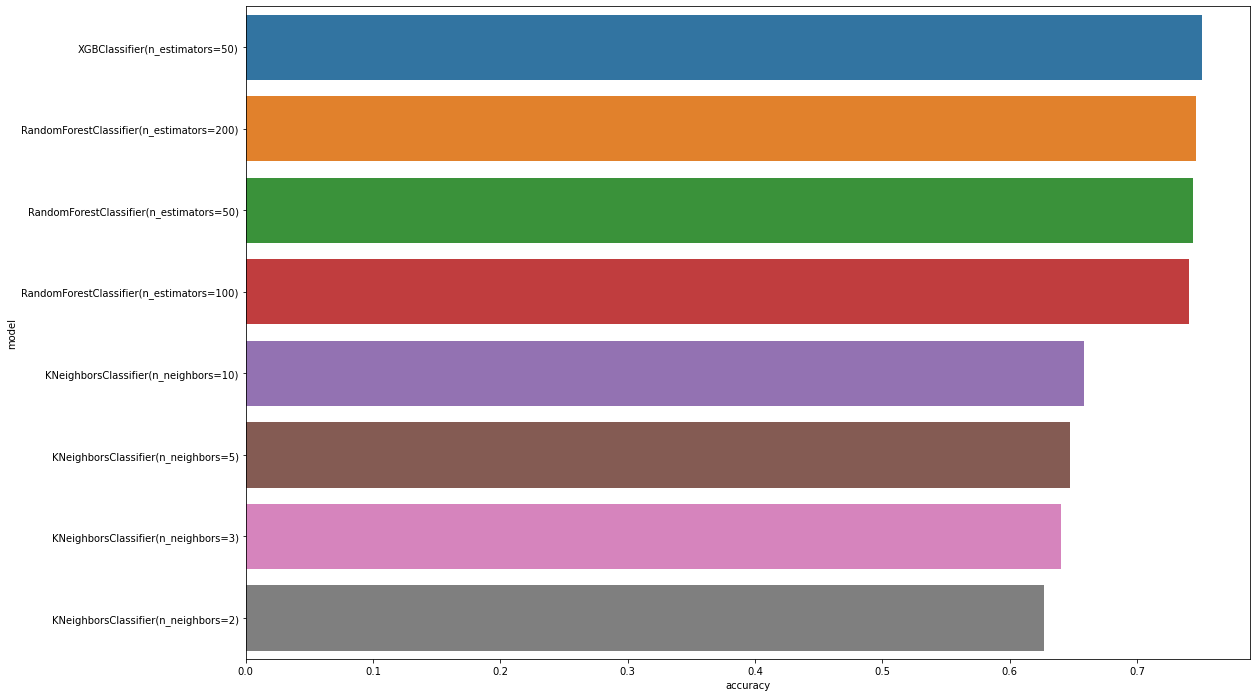

In [60]:
plot_result_accuracy(df_result_metrics)

### Feature importance

In [72]:
def get_feature_importance(model):
    return pd.DataFrame(sorted(list(zip(model.feature_importances_, X_2.columns)), reverse=True), columns=['importance', 'feature'])

In [73]:
def plot_feature_importance(df_feature_importance):
    plt.figure(figsize=(12, 12))
    sns.barplot(data=df_feature_importance.head(30), x='importance', y='feature')

In [74]:
df_feature_importance = get_feature_importance(models[7][0])
df_feature_importance

,importance,feature
0,0.035308,contains_fuck
1,0.032398,contains_good
2,0.027278,contains_wife
3,0.025920,contains_hooker
4,0.025837,contains_clean
5,0.025160,contains_like
6,0.024868,contains_'s
7,0.024416,contains_take
8,0.023941,contains_'m
9,0.023552,contains_house


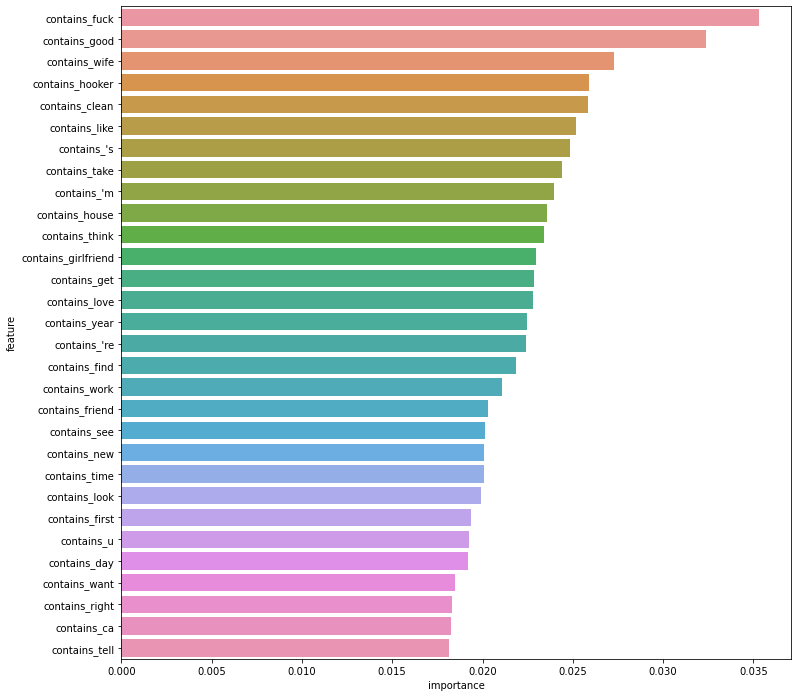

In [75]:
plot_feature_importance(df_feature_importance)

### Using Word2Vec (Problem 3)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_3, y['misogynous'].astype(int), test_size=0.2, random_state=42)

In [66]:
df_result_metrics, models = get_metrics_on_models(X_train, X_test, y_train, y_test)

 88%|████████▊ | 7/8 [00:16<00:01,  1.25s/it]

[22:27:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 8/8 [00:16<00:00,  2.08s/it]


In [67]:
df_result_metrics

,model,accuracy,precision_score,recall_score,f1_score
0,RandomForestClassifier(n_estimators=50),0.6280,0.645089,0.575697,0.608421
1,RandomForestClassifier(n_estimators=100),0.6335,0.652418,0.577689,0.612784
2,RandomForestClassifier(n_estimators=200),0.6350,0.654628,0.577689,0.613757
3,KNeighborsClassifier(n_neighbors=2),0.5900,0.696581,0.324701,0.442935
4,KNeighborsClassifier(n_neighbors=3),0.5935,0.614098,0.511952,0.558392
5,KNeighborsClassifier(n_neighbors=5),0.6195,0.650558,0.522908,0.579790
6,KNeighborsClassifier(n_neighbors=10),0.6090,0.684385,0.410359,0.513076
7,XGBClassifier(n_estimators=50),0.6130,0.618557,0.597610,0.607903


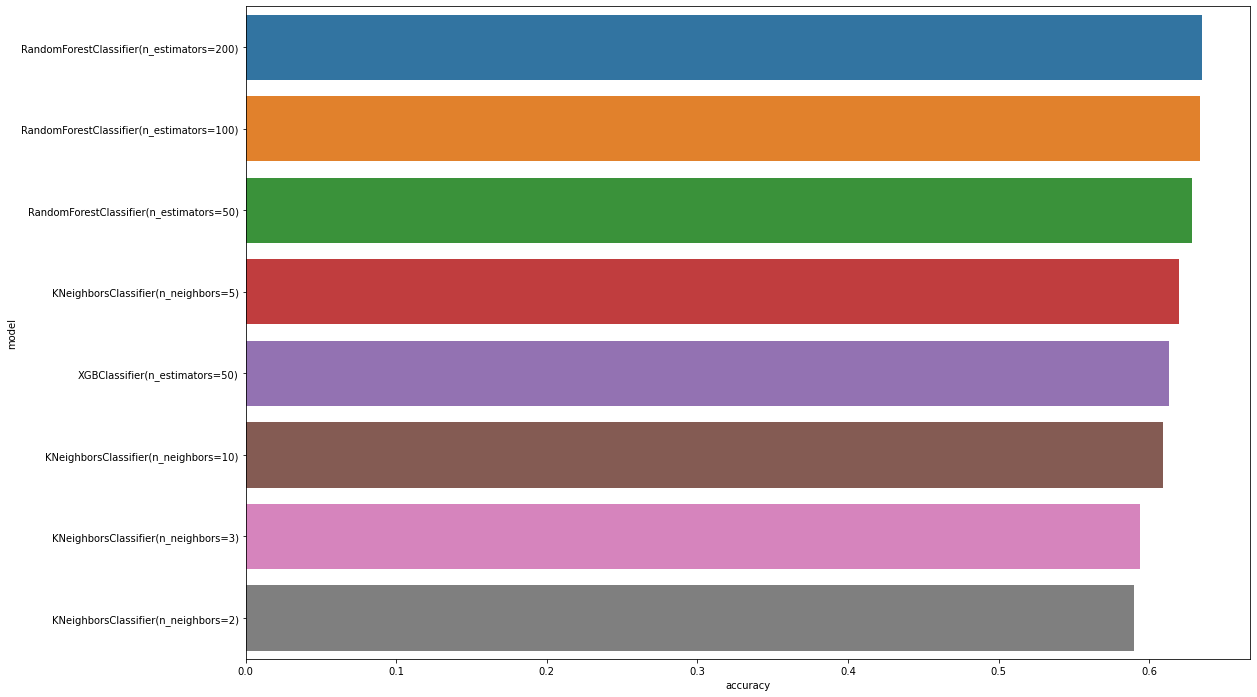

In [68]:
plot_result_accuracy(df_result_metrics)

## Conclusion

Models using Word2Vec embeddings were less accurate than those using n-gram features.